# Bengali AI Handwritten Grapheme Classification#

Import libraries and download dataset from kaggle, unzip parquet files, load in necessary weight and architecture of EffcientNetB4

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install Keras-Applications==1.0.8

     |████████████████████████████████| 51kB 2.8MB/s 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/Bengali Ai/efnB4.h5"

'/content/gdrive/MyDrive/Bengali Ai/efnB4.h5'


In [ ]:
from google.colab import files
#files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp "/content/gdrive/MyDrive/Bengali Ai/kaggle.json" ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c bengaliai-cv19

  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 89.7MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 4.21MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 84.5MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 848kB/s]
 99% 979M/986M [00:31<00:00, 39.6MB/s]
100% 986M/986M [00:31<00:00, 32.9MB/s]
 98% 977M/993M [00:24<00:00, 34.1MB/s]
100% 993M/993M [00:25<00:00, 41.6MB/s]
  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 4.84MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 88.9MB/s]
 99% 985M/992M [00:24<00:00, 51.7MB/s]
100% 992M/992M [00:24<00:00, 42.9MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 80.9MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.55MB/s]
  0% 0.00/16.8k [00:00<?, ?B/s]
100% 16.8k/16.8k [00:00<00:00, 17.2MB/s]
 98% 972M/991M [00:26<00:00, 21.0MB/s]
100% 991M/991M [00:26<00:00, 38.8MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1

In [ ]:
! unzip train_image_data_0.parquet.zip
! unzip train_image_data_1.parquet.zip
! unzip train_image_data_2.parquet.zip
! unzip train_image_data_3.parquet.zip


Archive:  train_image_data_0.parquet.zip
  inflating: train_image_data_0.parquet  
Archive:  train_image_data_1.parquet.zip
  inflating: train_image_data_1.parquet  
Archive:  train_image_data_2.parquet.zip
  inflating: train_image_data_2.parquet  
Archive:  train_image_data_3.parquet.zip
  inflating: train_image_data_3.parquet  


In [ ]:
! unzip test_image_data_0.parquet.zip
! unzip test_image_data_1.parquet.zip
! unzip test_image_data_2.parquet.zip
! unzip test_image_data_3.parquet.zip

Archive:  test_image_data_0.parquet.zip
  inflating: test_image_data_0.parquet  
Archive:  test_image_data_1.parquet.zip
  inflating: test_image_data_1.parquet  
Archive:  test_image_data_2.parquet.zip
  inflating: test_image_data_2.parquet  
Archive:  test_image_data_3.parquet.zip
  inflating: test_image_data_3.parquet  


In [ ]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#!pip install efficientnet >> /dev/null
!pip install '/content/gdrive/MyDrive/Bengali Ai/efficientnet-1.0.0-py3-none-any.whl' >> /dev/null

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 952kB 7.8MB/s 
     |████████████████████████████████| 38.2MB 131kB/s 
albumentations==0.5.2 is successfully installed


In [ ]:
# LOAD LIBRARIES
import time
startNB = time.time()
import tensorflow as tf, os
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score
import albumentations as albu, cv2, gc
#print('TensorFlow version =',tf.__version__)

In [ ]:
# CONFIGURE GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.list_physical_devices('GPU'); print(gpus)
if len(gpus)==1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Enable mix-precision training for speed up GPU training and save memory

In [ ]:
# ENABLE MIXED PRECISION for speed
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


Creating log and write to log.

We use 64X64 resolution which is enough for us to train the model and save much of spaces. We also applied batch-size to be 256 which is the maximum value that Colab GPU cann hold.

In [ ]:
# VERSION MAJOR and MINOR for logging
mm = 1; rr = 0

# BEGIN LOG FILE
f = open(f'log-{mm}-{rr}.txt','a')
print('Logging to "log-%i-%i.txt"'%(mm,rr))
f.write('#############################\n')
f.write(f'Trial mm={mm}, rr={rr}\n')
f.write('efNetB4, batch_size=512, seed=42, 64x64, fold=0, LR 1e-3 with 0.75 decay\n')
f.write('#############################\n')
f.close()

BATCH_SIZE = 256
DIM = 64

Logging to "log-1-0.txt"


##Preprocess Data ##

###Read In Files ###
Here we read four parquet files with resolution 64X64, normalized the value of image to (0,1), then concatenate them to numpy arrays for training.there are 200840 test images in total.

In [ ]:
%%time
train = []
for x in [0,1,2,3]:
#for x in [0]:
    f = 'train_image_data_%i.parquet'%x
    print (f,end='')
    img = pd.read_parquet('/content/'+f) # Pandas dataframe
    img = img.iloc[:,1:].values.reshape((-1,137,236,1)) # Numpy Array
    img2 = np.zeros((img.shape[0],DIM,DIM,1),dtype='float32')
    print(img2.shape)
    for j in range(img.shape[0]):
        img2[j,:,:,0] = cv2.resize(img[j,],(DIM,DIM),interpolation = cv2.INTER_AREA)
        if j%1000==0: print(j,', ',end='')
    print()
    img2 = (255 - img2)/255.
    train.append(img2)

train_image_data_0.parquet(50210, 64, 64, 1)
0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 , 11000 , 12000 , 13000 , 14000 , 15000 , 16000 , 17000 , 18000 , 19000 , 20000 , 21000 , 22000 , 23000 , 24000 , 25000 , 26000 , 27000 , 28000 , 29000 , 30000 , 31000 , 32000 , 33000 , 34000 , 35000 , 36000 , 37000 , 38000 , 39000 , 40000 , 41000 , 42000 , 43000 , 44000 , 45000 , 46000 , 47000 , 48000 , 49000 , 50000 , 
train_image_data_1.parquet(50210, 64, 64, 1)
0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 , 11000 , 12000 , 13000 , 14000 , 15000 , 16000 , 17000 , 18000 , 19000 , 20000 , 21000 , 22000 , 23000 , 24000 , 25000 , 26000 , 27000 , 28000 , 29000 , 30000 , 31000 , 32000 , 33000 , 34000 , 35000 , 36000 , 37000 , 38000 , 39000 , 40000 , 41000 , 42000 , 43000 , 44000 , 45000 , 46000 , 47000 , 48000 , 49000 , 50000 , 
train_image_data_2.parquet(50210, 64, 64, 1)
0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 

In [ ]:
X_train = np.concatenate(train)
print('Train Shape',X_train.shape)

Train Shape (200840, 64, 64, 1)


Delete unuseful parameters to save RAM for further training

In [ ]:
del img, img2, train
_ = gc.collect()

Here, we visualize some of the images in the training dataset. 

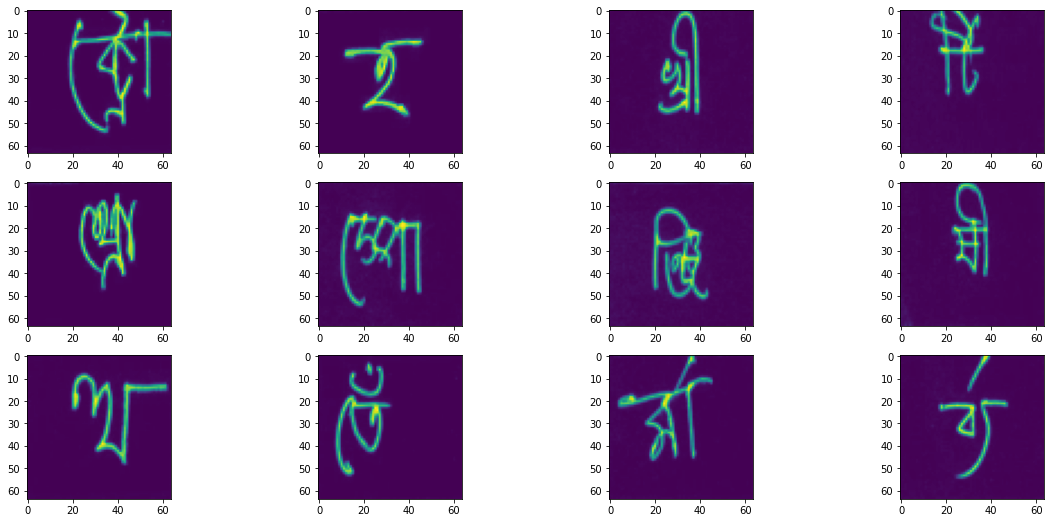

In [ ]:
row=3; col=4;
plt.figure(figsize=(20,(row/col)*12))
for x in range(row*col):
    plt.subplot(row,col,x+1)
    plt.imshow(X_train[x,:,:,0])
plt.show()

Then, we need to load the labels of each image in the training dataset.

In [ ]:
train = pd.read_csv('/content/train.csv')
y_train = train.iloc[:,1:4].values[:len(X_train)]
print('Labels\nGrapheme Root, Vowel Diacritic, Consonant Diacritic')
y_train

Labels
Grapheme Root, Vowel Diacritic, Consonant Diacritic


array([[ 15,   9,   5],
       [159,   0,   0],
       [ 22,   3,   5],
       ...,
       [  2,   1,   4],
       [152,   9,   0],
       [127,   2,   0]])

##Data Augmentation ##
Here we build data loader. we applied cutmix augmentation, which will take away a random part of one image(25%-40%) and replace this part with same part in another image(both image are in same grapheme type, like both vowel/consonant or root) to all data generated for every mini-batch, and applied mixShiftScaleRotate and CoarseDropout with both 50% percent the data for every mini-batch as well.

We also want to maximize batch size to fully utilize GPU compute.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, list_IDs, batch_size=BATCH_SIZE, shuffle=False, augment=False, 
            labels=True, cutmix=False, yellow=False): 

        self.X = X
        self.y = y
        self.augment = augment
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.cutmix = cutmix
        self.yellow = yellow
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.list_IDs) // self.batch_size
        ct += int((len(self.list_IDs) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X)
        if self.labels: return X, [y[:,0:168],y[:,168:179],y[:,179:186]]
        else: return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.list_IDs) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'        
        X = self.X[ self.list_IDs[indexes], ]
        if self.yellow: X = np.ones((len(indexes),DIM,DIM,1))
        y = np.zeros((len(indexes),186))
        for j in range(len(indexes)):
            y[j, int(self.y[ self.list_IDs[indexes[j]],0]) ] = 1
            y[j, 168 + int(self.y[ self.list_IDs[indexes[j]],1]) ] = 1
            y[j, 179 + int(self.y[ self.list_IDs[indexes[j]],2]) ] = 1
            
        if self.cutmix:
            for j in range(len(indexes)):
                
                # CHOOSE RANDOM CENTER
                yy = np.random.randint(0,DIM)
                xx = np.random.randint(0,DIM)
                z = np.random.choice(self.list_IDs)
                               
                # CHOOSE RANDOM WIDTH AND HEIGHT
                h = np.random.randint(DIM//2-DIM//16,DIM//2+DIM//16)
                w = np.random.randint(DIM//2-DIM//16,DIM//2+DIM//16)
                        
                # CUT AND MIX IMAGES
                ya = max(0,yy-h//2); yb = min(DIM,yy+h//2)
                xa = max(0,xx-w//2); xb = min(DIM,xx+w//2)
                X[j,ya:yb,xa:xb,0] = self.X[z,ya:yb,xa:xb,0]
                
                # CUT AND MIX LABELS
                r = (yb-ya)*(xb-xa)/DIM/DIM
                y2 = np.zeros((1,186))
                y2[0, int(self.y[ z,0]) ] = 1
                y2[0, 168 + int(self.y[ z,1]) ] = 1
                y2[0, 179 + int(self.y[ z,2]) ] = 1                
                y[j,] = (1-r)*y[j,] + r*y2[0,]
                    
        return X, y

    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.OneOf([
                        
                albu.ShiftScaleRotate(rotate_limit=8,scale_limit=0.16,shift_limit=0,border_mode=0,p=0.5),
                albu.CoarseDropout(max_holes=16,max_height=DIM//10,max_width=DIM//10,fill_value=0,p=0.5)
            ], p=0.5),
            albu.ShiftScaleRotate(rotate_limit=0, scale_limit=0., shift_limit=0.12, border_mode=0,value = 0, p=0.5)
        ])
        return composition(image=img)['image']
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch


Here, we display some of the images after cutmix augmentation with yellow coverage(yellow part doesn't show up when training)

Cutmix Augmentation with first image displayed as all yellow


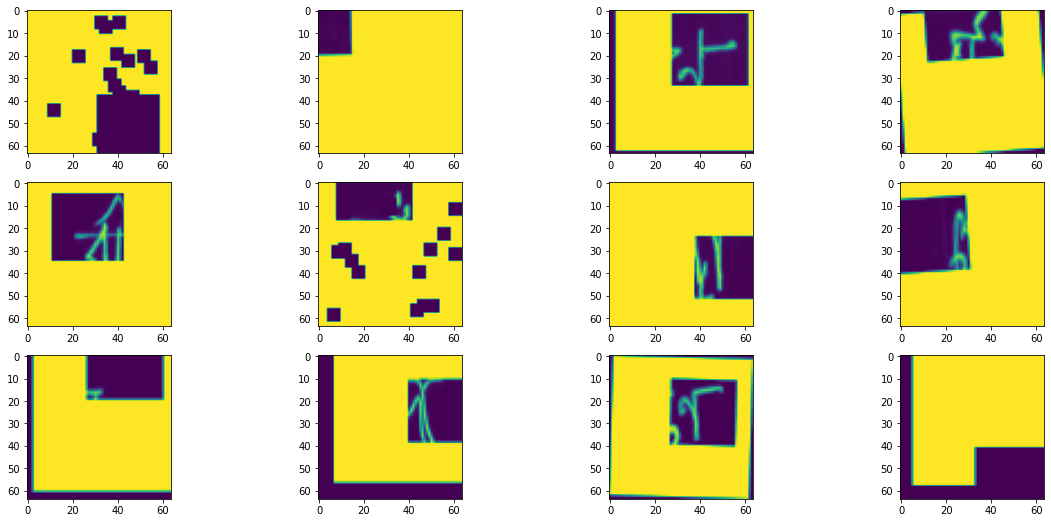

In [ ]:
print('Cutmix Augmentation with first image displayed as all yellow')
gen = DataGenerator(X_train,y_train,np.arange(len(X_train)),shuffle=True,augment=True,
            batch_size=BATCH_SIZE,cutmix=True,yellow=True)

row=3; col=4;
plt.figure(figsize=(20,(row/col)*12))
for batch in gen:
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.imshow(batch[0][j,:,:,0])
    plt.show()
    break

##Build and Train the Model ##
Here, we load the architecture of EffcientNetB4 and load the final training weight to this network. We use transfer learning and add three dense layer to each of three types which need to be classified, which are vowel/consonant diacritic and grapheme root.
The main model we want to train is these three dense layers, And we defined loss function with different weighted categorical cross entropy, and use adam optimizer with lr = 0.00001

In [ ]:
def build_model():
    
    inp = tf.keras.Input(shape=(DIM,DIM,1))
    inp2 = tf.keras.layers.Concatenate()([inp, inp, inp])
    #base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(DIM,DIM,3))
    base_model = efn.EfficientNetB4(weights=None,include_top=False, input_shape=(DIM,DIM,3)) 
    base_model.load_weights("/content/gdrive/MyDrive/Bengali Ai/efnB4.h5")

    x = base_model(inp2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)    
    x1 = tf.keras.layers.Dense(168, activation='softmax',name='x1',dtype='float32')(x)
    x2 = tf.keras.layers.Dense(11, activation='softmax',name='x2',dtype='float32')(x)
    x3 = tf.keras.layers.Dense(7, activation='softmax',name='x3',dtype='float32')(x)
    
    model = tf.keras.Model(inputs=inp, outputs=[x1,x2,x3])
    opt = tf.keras.optimizers.Adam(lr=0.00001)
    wgt = {'x1': 1.5, 'x2': 1.0, 'x3':1.0}
    model.compile(loss='categorical_crossentropy', optimizer = opt,\
              metrics=['categorical_accuracy'], loss_weights=wgt)
        
    return model

Here is the callback monitor that we defined to save evalution scores of the recall with 0.5 for root, 0.25 for both vowel and consonant. We also applied early stopping if the score is not changing after serveral epoches to speed up training and avoid overfitting

In [52]:
from sklearn.metrics import f1_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, target, fold, mm=0, rr=0, patience=10):
        self.valid_inputs = valid_data
        self.valid_outputs = target
        self.fold = fold
        self.patience = patience
        self.mm = mm
        self.rr = rr
        
    def on_train_begin(self, logs={}):
        self.valid_f1 = [0]
        self.valid_r1 = [0]
        self.valid_r2 = [0]
        self.valid_r3 = [0]
        
    def on_epoch_end(self, epoch, logs={}):
        
        preds = self.model.predict(self.valid_inputs)
        preds0 = np.argmax(preds[0],axis=1)
        preds1 = np.argmax(preds[1],axis=1)
        preds2 = np.argmax(preds[2],axis=1)
        
        r1 = recall_score(self.valid_outputs[0],preds0,average='macro')
        r2 = recall_score(self.valid_outputs[1],preds1,average='macro')
        r3 = recall_score(self.valid_outputs[2],preds2,average='macro')
                
        a1 = accuracy_score(self.valid_outputs[0],preds0)
        a2 = accuracy_score(self.valid_outputs[1],preds1)
        a3 = accuracy_score(self.valid_outputs[2],preds2)
        
        f1 = 0.5*r1+0.25*r2+0.25*r3
                
                 # LOG TO FILE
        f = open('log-%i-%i.txt'%(self.mm,self.rr),'a')
        f.write('#'*25); f.write('\n')
        f.write('#### FOLD %i EPOCH %i\n'%(self.fold+1,epoch+1))
        f.write('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f\n' % (a1,a2,a3) )
        f.write('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f\n' % (r1,r2,r3) )
        f.write('#### CV/LB: %.5f\n' % f1 ) 
       
        print('\n'); print('#'*25)
        print('#### FOLD %i EPOCH %i'%(self.fold+1,epoch+1))
        print('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f' % (a1,a2,a3) )
        print('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f' % (r1,r2,r3) )
        print('#### CV/LB: %.5f' % f1 )
        print('#'*25)

        self.valid_f1.append(f1)
        x = np.asarray(self.valid_f1)
        self.valid_r1.append(r1)
        x = np.asarray(self.valid_r1)
        self.valid_r2.append(r2)
        x = np.asarray(self.valid_r2)
        self.valid_r3.append(r3)
        x = np.asarray(self.valid_r3)
        if np.argsort(-x)[0]==(len(x)-self.patience-1):
            print('#### CV/LB no increase for %i epochs: EARLY STOPPING' % self.patience)
            f.write('#### CV/LB no increase for %i epochs: EARLY STOPPING\n' % self.patience)
            self.model.stop_training = True
            
        if (f1>0.000)&(f1>np.max(self.valid_f1[:-1])):
            print('#### Saving new best...')
            f.write('#### Saving new best...\n')
            self.model.save_weights('fold%i-m%i-%i.h5' % (self.fold,self.mm,self.rr))
            
        f.close()

Here is the learning rate we applied to train our model, we increase the learning rate from 0.00001 to 0.001 in first five epoches, and applied a learning rate decay with a rate of 0.75 every 5 epoches.

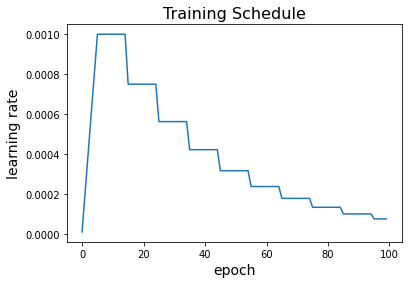

In [ ]:
# CUSTOM LEARNING SCHEUDLE
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

Here we train the model with 5-fold and 20 epoched for each fold, meanwhile saving the best fold to use for further prediction.

In [53]:
# TRAIN MODEL

oof1 = np.zeros((X_train.shape[0],168))
oof2 = np.zeros((X_train.shape[0],11))
oof3 = np.zeros((X_train.shape[0],7))


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold,(idxT,idxV) in enumerate(skf.split(X_train,y_train[:,0])):
         
    print('#'*25)
    print('### FOLD %i' % (fold+1))
    print('### train on %i images. validate on %i images'%(len(idxT),len(idxV)))
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    
    train_gen = DataGenerator(X_train,y_train,idxT,shuffle=True,augment=True,
            batch_size=BATCH_SIZE,cutmix=True)
    val_x = DataGenerator(X_train,y_train,idxV,shuffle=False,augment=False,cutmix=False,
            labels=False,batch_size=BATCH_SIZE*4)
    val_y = [y_train[idxV,0],y_train[idxV,1],y_train[idxV,2]]
        

    cc = CustomCallback(valid_data=val_x, target=val_y, fold=fold, mm=mm, rr=rr, patience=15)
    h = model.fit(train_gen, epochs = 20, verbose=1, callbacks=[cc,lr2])

    print('#### Loading best weights...')
    model.load_weights('fold%i-m%i-%i.h5' % (fold,mm,rr))
    

    val_x = DataGenerator(X_train,y_train,idxV,shuffle=False,augment=False,cutmix=False,
            labels=False,batch_size=BATCH_SIZE*4)
    oo = model.predict(val_x)
    oof1[idxV,] = oo[0]
    oof2[idxV,] = oo[1]
    oof3[idxV,] = oo[2]

    # SAVE OOF and IDXV
    np.save('oof1-%i-%i'%(mm,rr),oof1)
    np.save('oof2-%i-%i'%(mm,rr),oof2)
    np.save('oof3-%i-%i'%(mm,rr),oof3)
    np.save('idxV-%i-%i'%(mm,rr),idxV)
    np.save('y_train-%i-%i'%(mm,rr),y_train)
    break


#########################
### FOLD 1
### train on 160672 images. validate on 40168 images
#########################
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
628/628 [==============================] - 219s 269ms/step - loss: 12.2137 - x1_loss: 5.2287 - x2_loss: 2.4410 - x3_loss: 1.9297 - x1_categorical_accuracy: 0.0067 - x2_categorical_accuracy: 0.1235 - x3_categorical_accuracy: 0.2313


#########################
#### FOLD 1 EPOCH 1
#### ACCURACY: a1=0.01088, a2=0.26456, a3=0.59124
#### MACRO RECALL: r1=0.00704, r2=0.16150, r3=0.15083
#### CV/LB: 0.08160
#########################
#### Saving new best...
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000208.
628/628 [==============================] - 201s 320ms/step - loss: 9.8507 - x1_loss: 4.6238 - x2_loss: 1.7896 - x3_loss: 1.1254 - x1_categorical_accuracy: 0.0470 - x2_categorical_accuracy: 0.4216 - x3_categorical_accuracy: 0.6425


#########################
#### FOLD 

here, we visualize the loss and score of each categorical accuracy

In [61]:
loss = h.history["loss"]
loss1 = h.history["x1_loss"]
loss2 = h.history["x2_loss"]
loss3 = h.history["x3_loss"]
f1s= cc.valid_f1
r1s = cc.valid_r1
r2s = cc.valid_r2
r3s = cc.valid_r3


[0,
 0.007041613502529155,
 0.16499865036837627,
 0.642884193499014,
 0.7652757185564295,
 0.8264469732286803,
 0.8377817820794768,
 0.8746347431566568,
 0.8659657416545459,
 0.8952207832717456,
 0.8876709702578208,
 0.9093726251187267,
 0.9179171702250224,
 0.9243297155918135,
 0.9311664782787704,
 0.9315711215131441,
 0.9412814339731492,
 0.9364742306604684,
 0.9485843787996383,
 0.9465201220300298,
 0.9511739126791825]

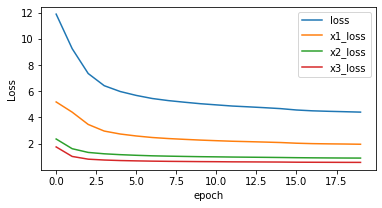

In [59]:
plt.figure(figsize = (6,3))
plt.plot(loss, label = "loss")
plt.plot(loss1, label = "x1_loss")
plt.plot(loss2, label = "x2_loss")
plt.plot(loss3, label = "x3_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

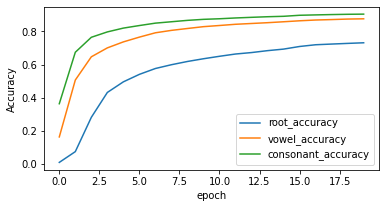

In [67]:
plt.figure(figsize = (6,3))

plt.plot(h.history["x1_categorical_accuracy"], label = "root_accuracy")
plt.plot(h.history["x2_categorical_accuracy"], label = "vowel_accuracy")
plt.plot(h.history["x3_categorical_accuracy"], label = "consonant_accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

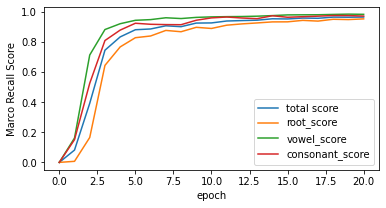

In [66]:
plt.figure(figsize = (6,3))
plt.plot(f1s, label = "total score")
plt.plot(r1s, label = "root_score")
plt.plot(r2s, label = "vowel_score")
plt.plot(r3s, label = "consonant_score")
plt.xlabel("epoch")
plt.ylabel("Marco Recall Score")
plt.legend()
plt.show()

Here we validate the data with the out-of-fold validation and compute the final score.

In [ ]:
oo = model.predict(val_x,verbose=1)
oof1[idxV,] = oo[0]
oof2[idxV,] = oo[1]
oof3[idxV,] = oo[2]

40/40 [==============================] - 8s 201ms/step


In [ ]:
oof1b = np.argmax(oof1[idxV,],axis=1)
oof2b = np.argmax(oof2[idxV,],axis=1)
oof3b = np.argmax(oof3[idxV,],axis=1)

r1 = recall_score(y_train[idxV,0],oof1b,average='macro')
r2 = recall_score(y_train[idxV,1],oof2b,average='macro')
r3 = recall_score(y_train[idxV,2],oof3b,average='macro')
r = 0.5*r1+0.25*r2+0.25*r3
print('CV/LB without Post Process %.5f'%r)

CV/LB without Post Process 0.96418


Here is a very tricky approach thich is called post process, which we reduce the weight of graphemes with more appearance for when predicting the result. This could give an increase to predict relatively rare cases in the out-of-fold validation dataset. And this trick works quite well on this problem.

In [ ]:
EXP = -0.9

s = pd.Series(oof1b)
vc = s.value_counts().sort_index()
mat1 = np.diag(vc.astype('float32')**(EXP))

s = pd.Series(oof2b)
vc = s.value_counts().sort_index()
mat2 = np.diag(vc.astype('float32')**(EXP))

s = pd.Series(oof3b)
vc = s.value_counts().sort_index()
mat3 = np.diag(vc.astype('float32')**(EXP))

In [ ]:
oof1b = np.argmax(oof1[idxV,].dot(mat1),axis=1)
oof2b = np.argmax(oof2[idxV,].dot(mat2),axis=1)
oof3b = np.argmax(oof3[idxV,].dot(mat3),axis=1)

r1 = recall_score(y_train[idxV,0],oof1b,average='macro')
r2 = recall_score(y_train[idxV,1],oof2b,average='macro')
r3 = recall_score(y_train[idxV,2],oof3b,average='macro')
r = 0.5*r1+0.25*r2+0.25*r3
print('CV/LB with Post Process %.5f'%r)

CV/LB with Post Process 0.97002


##Test the Prediction  ##

### Load and Preprocess Test Data###

Here, we preprocess test dataset and applied post process on test set. Here, we only have 12 samples in the test set, so we will try to visualize them.



In [ ]:
def getTest(x):
    f = 'test_image_data_%i.parquet'%x
    img = pd.read_parquet('/content/'+f) # Pandas dataframe
    img = img.iloc[:,1:].values.reshape((-1,137,236,1)) # Numpy Array
    img2 = np.zeros((img.shape[0],DIM,DIM,1),dtype='float32')
    for j in range(img.shape[0]):
        img2[j,:,:,0] = cv2.resize(img[j,],(DIM,DIM),interpolation = cv2.INTER_AREA)
    return (255 - img2)/255.

In [ ]:
EXP = -0.9
#del X_train; gc.collect()

# LOAD BEST MODEL
model.load_weights('fold%i-m%i-%i.h5' % (fold,mm,rr))

# PREDICT TEST
preds1 = []; preds2 = []; preds3 = []
for x in [0,1,2,3]:
    preds = model.predict(getTest(x),verbose=1)
    preds1.append(preds[0])
    preds2.append(preds[1])
    preds3.append(preds[2])

pred1 = np.argmax(np.vstack(preds1),axis=1)
pred2 = np.argmax(np.vstack(preds2),axis=1)
pred3 = np.argmax(np.vstack(preds3),axis=1)


# APPLY POST PROCESS
s = pd.Series(pred1)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(168),'b':np.ones(168)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat1 = np.diag(df.b.astype('float32')**(EXP))

s = pd.Series(pred2)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(11),'b':np.ones(11)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat2 = np.diag(df.b.astype('float32')**(EXP))

s = pd.Series(pred3)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(7),'b':np.ones(7)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat3 = np.diag(df.b.astype('float32')**(EXP))

# APPLY POST PROCESS
pred1 = np.argmax(np.vstack(preds1).dot(mat1),axis=1)
pred2 = np.argmax(np.vstack(preds2).dot(mat2),axis=1)
pred3 = np.argmax(np.vstack(preds3).dot(mat3),axis=1)


1/1 [==============================] - 0s 56ms/step


In [ ]:
%%time
test = []
for x in [0,1,2,3]:
#for x in [0]:
    f = 'test_image_data_%i.parquet'%x
    print (f,end='')
    img = pd.read_parquet('/content/'+f) # Pandas dataframe
    img = img.iloc[:,1:].values.reshape((-1,137,236,1)) # Numpy Array
    img2 = np.zeros((img.shape[0],DIM,DIM,1),dtype='float32')
    print(img2.shape)
    for j in range(img.shape[0]):
        img2[j,:,:,0] = cv2.resize(img[j,],(DIM,DIM),interpolation = cv2.INTER_AREA)
        if j%1000==0: print(j,', ',end='')
    print()
    img2 = (255 - img2)/255.
    test.append(img2)


test_image_data_0.parquet(3, 64, 64, 1)
0 , 
test_image_data_1.parquet(3, 64, 64, 1)
0 , 
test_image_data_2.parquet(3, 64, 64, 1)
0 , 
test_image_data_3.parquet(3, 64, 64, 1)
0 , 
CPU times: user 1min 15s, sys: 1.73 s, total: 1min 17s
Wall time: 1min 14s


###Visualize the Prediction Result ###

Here we want to visualize the predicted unicode Bengali and compare them to the images in the test dataset

In [ ]:
X_test = np.concatenate(test)
classmap = pd.read_csv('/content/class_map.csv'); 
preds1=[];preds2=[];preds3 = [];preds = []

for i in range(X_test.shape[0]):
  preds1.append(classmap.iloc[pred1[i],2])
  if pred2[i] !=0 :
    preds2.append(classmap.iloc[pred2[i]+168,2])
  else:
    preds2.append("")
  if pred3[i] !=0:
    preds3.append(classmap.iloc[pred3[i]+168+11,2])
  else :
    preds3.append("")
  preds.append(preds1[i] + preds2[i] + preds3[i]) 
preds

['আ',
 'ন্বি',
 'ক্ষ্ণ',
 'ম',
 'ঠু',
 'মির্',
 'গো্র',
 'শ্মে',
 'ম্ভো',
 'শৌ',
 'স্কা্য',
 'ক্সি']

Here we can see the image in test and corresponding predicted Bengali unicode.

আ ন্বি ক্ষ্ণ ম ঠু মির্ গো্র শ্মে ম্ভো শৌ স্কা্য ক্সি 

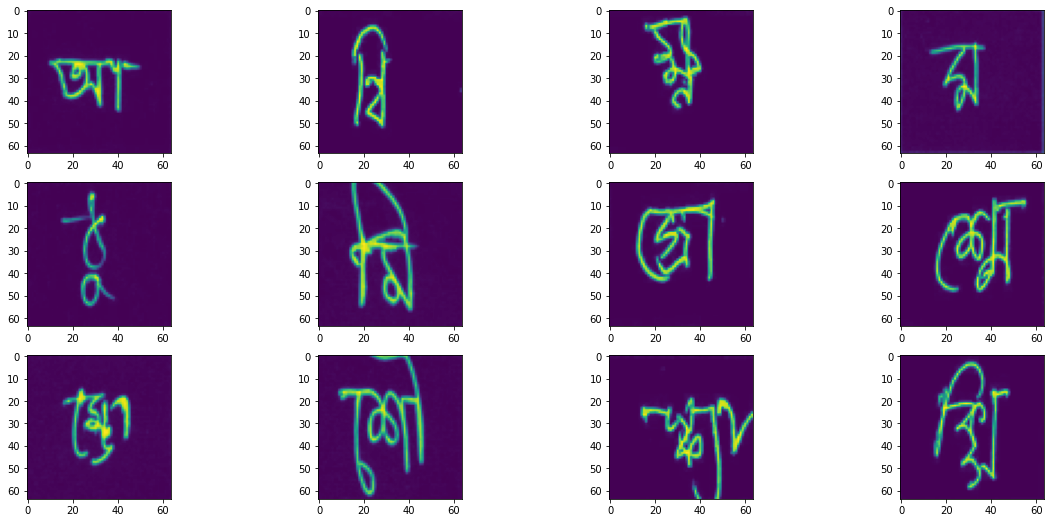

In [ ]:
X_test = np.concatenate(test)
row=3; col=4;
plt.figure(figsize=(20,(row/col)*12))
for x in range(row*col):
    plt.subplot(row,col,x+1)
    plt.imshow(X_test[x,:,:,0])
    print(preds[x], end = ' ')
plt.show()

  

Last part is used for submit on kaggle

In [ ]:
row_id = []; target = []
for i in range(len(pred1)):
    row_id += [f'Test_{i}_grapheme_root', f'Test_{i}_vowel_diacritic', f'Test_{i}_consonant_diacritic']
    target += [pred1[i], pred2[i], pred3[i]]
sub = pd.DataFrame({'row_id': row_id, 'target': target})
sub.to_csv('submission.csv', index=False)
sub.head()

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
